In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import concurrent.futures as cf
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import  accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# here I get the data I use and also the 13 month data for one thing later 
X=pd.read_csv("./final_train_X.csv").iloc[:,3:]
y=pd.read_csv("./final_train_y.csv").iloc[:,1:]
X_great=pd.read_csv("great_test_X.csv").iloc[:,3:]
y_great=pd.read_csv("great_test_y.csv").iloc[:,1:]

In [3]:
# so that I could use the 13 month data I have to take out columns from both X and X_great the 13 month data
# because diferent month data have diferent NaN ratios in diferent columns so some of them got drop from one X but not the other 
# also it would be nice for the preprocess if the order of the columns be the same
inter_col=X[np.intersect1d(X.columns,X_great.columns)].columns
X=X[inter_col]
X_great=X_great[inter_col]

In [4]:
# here I make a train test split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=.3,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16259, 161)
(16259, 1)
(6969, 161)
(6969, 1)


In [5]:
# cheack if they are balance
y_test.describe()

,target
count,6969.000000
mean,0.500502
std,0.500036
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
y_train.describe()

,target
count,16259.000000
mean,0.499785
std,0.500015
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
# make a imputer pipe line and train it for X train
categorical=list(X_train.select_dtypes("object").columns)
numerical=list(X_train.select_dtypes("number").columns)

cat_pipe=Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
    ("encoder",OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)),
    ("scaler",StandardScaler())
    ])

num_pipe=Pipeline([
("imputer",KNNImputer(n_neighbors=5,weights="uniform",missing_values=np.nan)),
("scaler",StandardScaler())
])

preprocess=ColumnTransformer([("cat",cat_pipe,categorical), 
("num",num_pipe,numerical)])


preprocess.fit(X_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['D_63', 'D_64']),
                                ('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['B_11', 'B_12', 'B_13', 'B_14', 'B_15',
                                  'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 'B_20',
                                  'B_21', 'B_22', 'B_23', 'B_24', 'B_25',
                                  'B_26', 'B_27', 'B_28', 'B_3', 'B_30', 'B_31',
                                  'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_4',
                                  'B_40', 'B_41', ...])])

In [8]:
# process X
X_train=preprocess.transform(X_train)

In [9]:
# create a df to cheack the columns score of importance
skb=SelectKBest(k="all")
skb.fit(X_train,y_train.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 159] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


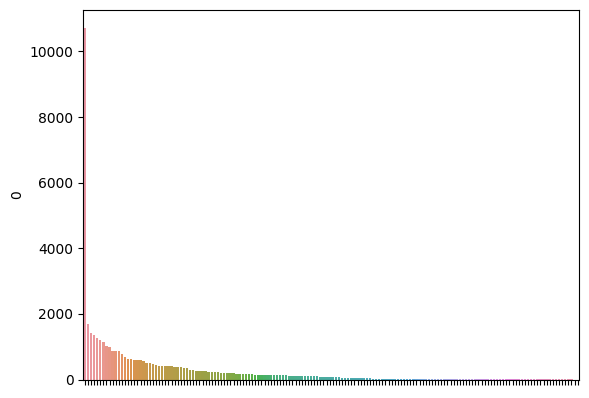

In [10]:
# that column is to high in train
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

In [11]:
# do it for test
skb=SelectKBest(k="all")
skb.fit(preprocess.transform(X_test),y_test.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 159] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


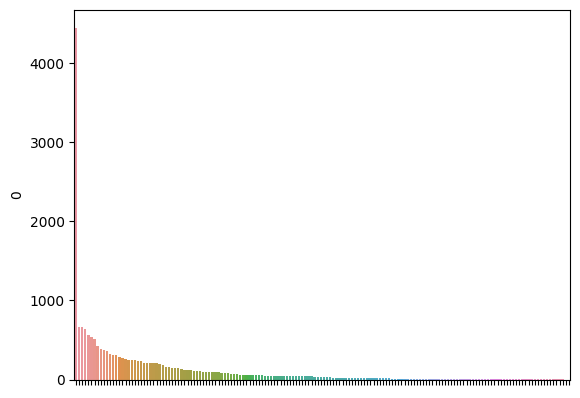

In [12]:
# also to high in test
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

In [13]:
# check it on the 13 month data
temp=preprocess.transform(X_great)

In [14]:
skb=SelectKBest(k="all")
skb.fit(temp,y_great.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 159] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


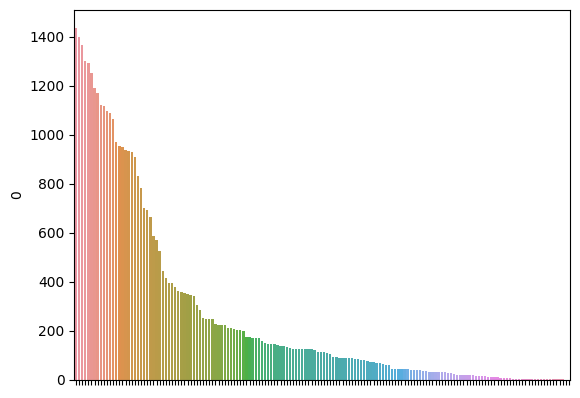

In [15]:
# no spike here
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

In [16]:
# create an array with the top col
skb=SelectKBest(k=1)
skb.fit(X_train,y_train.values.reshape(1,-1)[0])
data_X=skb.transform(X_train)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 159] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [17]:
# check its index
num_col=list(filter(lambda x: x if data_X.tolist()==X_train[:,x].reshape(-1,1).tolist() else None,range(0,159)))

In [18]:
# this is the column is a spending column
X.iloc[:,num_col[0]]

0        0.001860
1        0.076201
2        0.006732
3        0.042243
4        0.047504
           ...   
23223    0.003729
23224    0.109330
23225    0.000094
23226    0.215608
23227    0.005274
Name: S_5, Length: 23228, dtype: float64

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 158] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


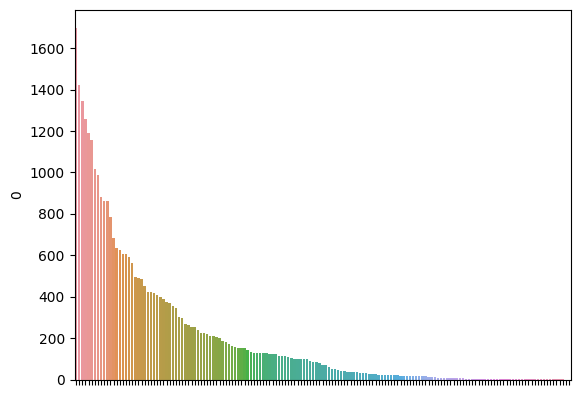

In [19]:
# drop the column and cheack if it is out
X_train=pd.DataFrame(X_train)
X_train=X_train.drop(num_col[0],axis=1)
skb=SelectKBest(k="all")
skb.fit(X_train,y_train.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

In [20]:
# drop col and transform with the preprocess X_test and great_X
X_test=preprocess.transform(X_test)
X_test=pd.DataFrame(X_test)
X_test=X_test.drop(num_col[0],axis=1)
X_great=pd.DataFrame(temp)
X_great=X_great.drop(num_col[0],axis=1)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 158] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


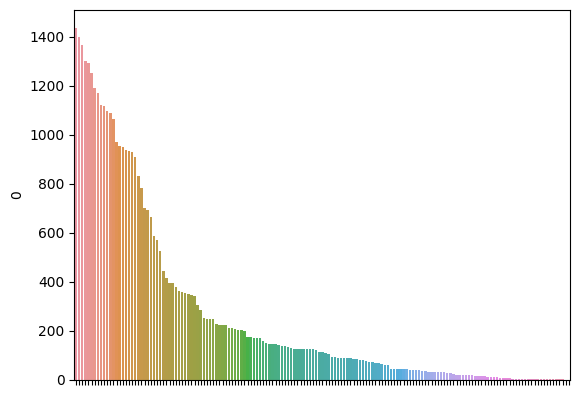

In [32]:
# check the great_X again
skb=SelectKBest(k="all")
skb.fit(X_great,y_great.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 158] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


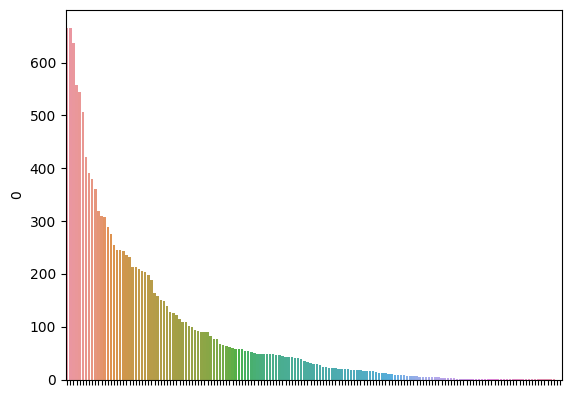

In [31]:
# cheack the X_test with the drop comlumn
skb=SelectKBest(k="all")
skb.fit(X_test,y_test.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

In [39]:
# now pick up holy the top 25 following the rule of log(n)*5 a bit above
skb=SelectKBest(k=25)
skb.fit(X_train,y_train)
X_train=skb.transform(X_train)
X_test=skb.transform(X_test)
X_great=skb.transform(X_great)

c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [109 158] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Joni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [54]:
final_pre_pipe=Pipeline([("preprocess",preprocess),("skb",skb)])

In [55]:
final_pre_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['D_63', 'D_64']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['B_11', 'B_12', 'B_13',
                                                   'B_14', 'B_15', 'B_16',
                                                   'B_17', 'B_18', 'B_19',
                                                   'B_2', 'B_20', 'B_21',
                                                   'B_22', 'B_23', 'B_24',
                                                   'B_25', 'B_26', 'B_27',
                                                   'B_28', 'B_3', 'B_30',
                                                   'B_31', 'B_32', 'B_33',
                                                   'B_36', 'B_37', 'B_38',
                                                   'B_4', 'B_40', 'B_41', ...])])),
                ('skb', SelectKBest(k='all'))])

In [47]:
pd.DataFrame(X_train).to_csv("process_X_train.csv")
pd.DataFrame(y_train).to_csv("process_y_train.csv")
pd.DataFrame(X_test).to_csv("process_X_test.csv")
pd.DataFrame(y_test).to_csv("process_y_test.csv")
pd.DataFrame(X_great).to_csv("process_X_great.csv")
pd.DataFrame(y_great).to_csv("process_y_great.csv")

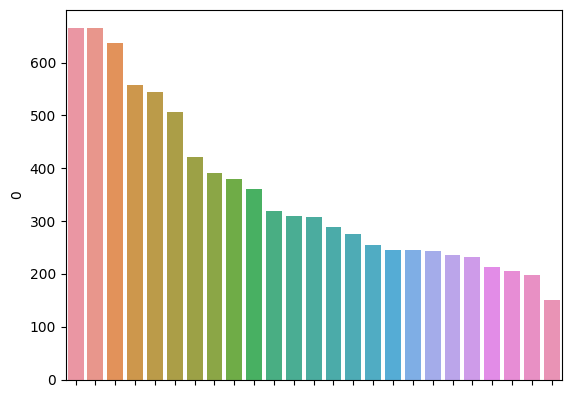

In [46]:
# and this is the distribuition of the new columns from X_train
skb=SelectKBest(k="all")
skb.fit(X_test,y_test.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

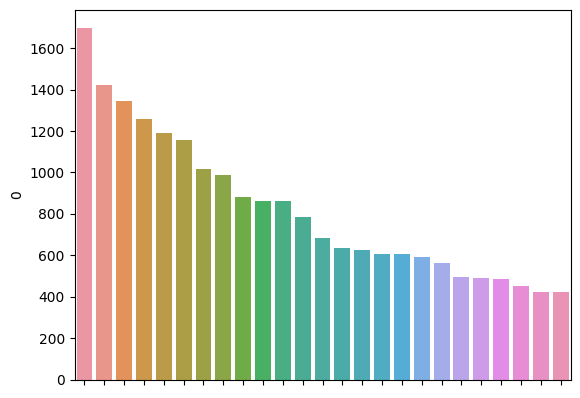

In [45]:
#X_test
skb=SelectKBest(k="all")
skb.fit(X_train,y_train.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);

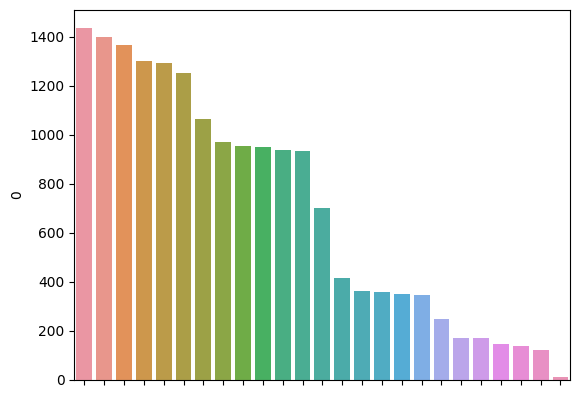

In [44]:
# and X_great just for fun
skb=SelectKBest(k="all")
skb.fit(X_great,y_great.values.reshape(1,-1)[0])
imp_feat=pd.DataFrame(skb.scores_).sort_values(0,ascending=False)
graph=sns.barplot(x=imp_feat.index,y=imp_feat[0], order=imp_feat.index)
graph.set(xticklabels=[]);